### Prophet: A Modular Regression Model for Time Series Forecasting

Prophet is a flexible and powerful tool for time series forecasting developed by Facebook. It is designed to accommodate the linear/non-linear modeling needs while providing robust performance for analysts and data scientists.

#### Key Features and Components

1. **Trend Modeling**:
   - **Piecewise Linear Trends**: Prophet models trends as piecewise linear functions, allowing for changes in growth rates at specified changepoints. This makes it adaptable to various business scenarios where growth patterns shift due to market conditions or other factors.
   - **Nonlinear Saturating Growth**: For time series that grow and saturate, Prophet employs a logistic growth model. This is particularly useful for products or services approaching market saturation.

2. **Seasonality**:
   - **Yearly Seasonality**: Captures annual patterns using Fourier series, which can represent periodic fluctuations.
   - **Weekly Seasonality**: Addresses weekly cycles common in business operations, such as increased activity on weekdays compared to weekends.
   - **Daily Seasonality**: Handles daily patterns, which is crucial for time series with high-frequency data.

3. **Holidays and Special Events**:
   - Prophet can incorporate the effects of holidays and special events by allowing users to specify known events that influence the time series. These events are included as additional regressors, improving forecast accuracy.

#### Model Equation

Prophet decomposes the time series y(t) into three main components: trend g(t), seasonality s(t), and holidays h(t). The model can be expressed as:

y(t) = g(t) + s(t) + h(t) + ε(t)


Where:
- g(t) is the trend function which models non-periodic changes in the value of the time series.
- s(t) represents periodic changes (e.g., weekly and yearly seasonality).
- h(t) accounts for the effects of holidays which occur on potentially irregular schedules over one or more days.
- epsilon_t is the error term which captures any idiosyncratic changes not accounted for by the model.

For the logistic growth model, the trend component g(t) is defined as:

g(t)= C(t) / 1+exp(−k(t−m))

Where:
- ( C(t) ) is the carrying capacity.
- ( k ) is the growth rate.
- ( m ) is the offset parameter, representing the midpoint of growth.

#### Model Implementation and Workflow

**Imports**

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
import warnings
import yfinance as yf
import seaborn as sns; sns.set()
yf.pdr_override() 
%matplotlib inline
warnings.filterwarnings('ignore')
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

1. **Data Preparation**:
   - The input data must be a dataframe with two columns: `ds` (date) and `y` (numeric value to forecast).
   - Prophet handles missing data and outliers gracefully.

In [44]:
def collect (tickers, start_date, end_date):
    stock_data= yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    stock_data.dropna(inplace=True)
    return stock_data

stock_name = ['TSLA']
start_date= datetime.now().replace(year=datetime.now().year-2, day=1)
end_date=datetime.now()
# convert date to string format
start_date = start_date.strftime("%Y-%m-%d")
end_date = end_date.strftime("%Y-%m-%d")

# collect the data
df = collect(stock_name, start_date, end_date)
df = df.reset_index()
df.columns = ['ds','y']
df

[*********************100%%**********************]  1 of 1 completed


,ds,y
0,2022-06-01,246.789993
1,2022-06-02,258.333344
2,2022-06-03,234.516663
3,2022-06-06,238.279999
4,2022-06-07,238.886673
...,...,...
507,2024-06-07,177.479996
508,2024-06-10,173.789993
509,2024-06-11,170.660004
510,2024-06-12,177.289993


##### Note: I have downloaded the stock closing price for Tesla

2. **Fitting the Model**:

In [48]:
# Instantiate the Prophet model and fit it to the historical data.
m = Prophet()
m.fit(df)

16:47:53 - cmdstanpy - INFO - Chain [1] start processing
16:47:53 - cmdstanpy - INFO - Chain [1] done processing


3. **Making Predictions**:

In [53]:
# Create a future dataframe of 90 days and make predictions.
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

In [55]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
597,2024-09-07,210.596928,182.434175,236.781352
598,2024-09-08,211.344146,185.862437,236.398896
599,2024-09-09,204.484487,177.267227,229.517014
600,2024-09-10,204.667229,177.849315,232.052065
601,2024-09-11,205.556156,178.088408,231.617337


4. **Visualization**:

In [58]:
# Plot the forecast and its components (trend, yearly, weekly, and daily seasonality).

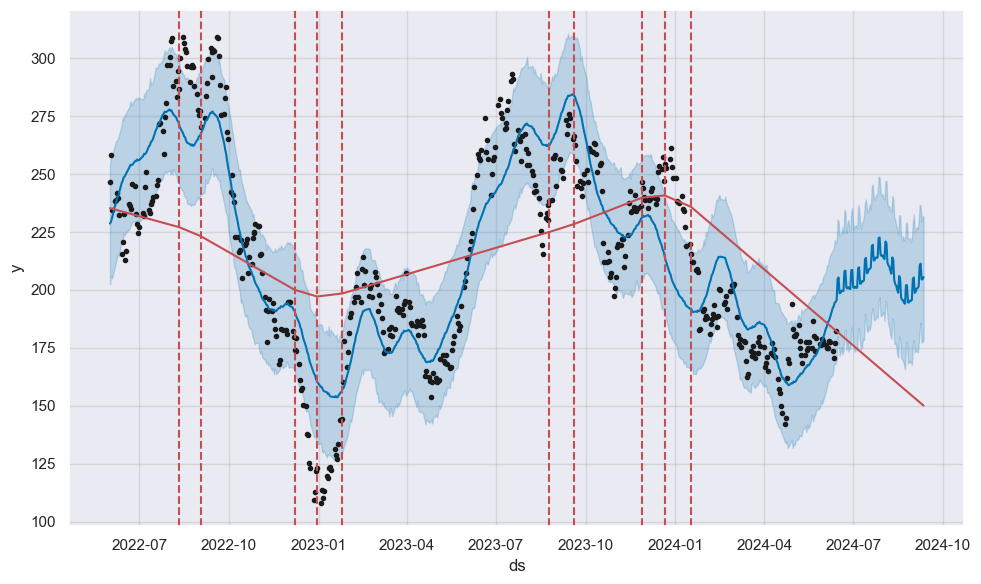

In [60]:
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

# Showing changepoints in history for trend adjustment

**The forecast plot** includes the historical data, the predicted values (yhat), and the uncertainty intervals, changepoints from 80% of history data, visualizing the model's predictions and their reliability.

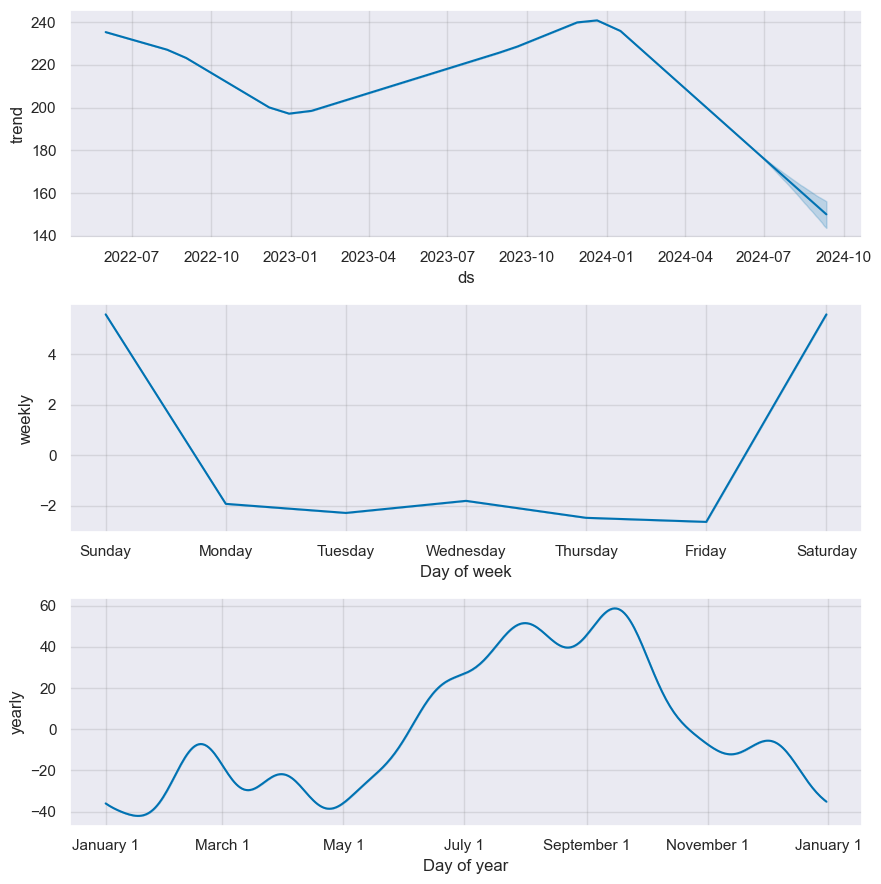

In [65]:
fig2 = m.plot_components(forecast)

**Trend and Seasonal Components** shows the decomposition of the forecast into trend, yearly seasonality, weekly seasonality, and special events, providing insights into the underlying patterns of the time series.

## Compare with ARIMA

16:55:06 - cmdstanpy - INFO - Chain [1] start processing
16:55:06 - cmdstanpy - INFO - Chain [1] done processing


Evaluation on last 90 days:
Prophet - MAE: 28.4539, RMSE: 32.7989, MAPE: 16.74%, sMAPE: 15.01%
ARIMA - MAE: 10.5379, RMSE: 13.2800, MAPE: 6.15%, sMAPE: 5.94%
SARIMA - MAE: 10.5379, RMSE: 13.2800, MAPE: 6.15%, sMAPE: 5.94%


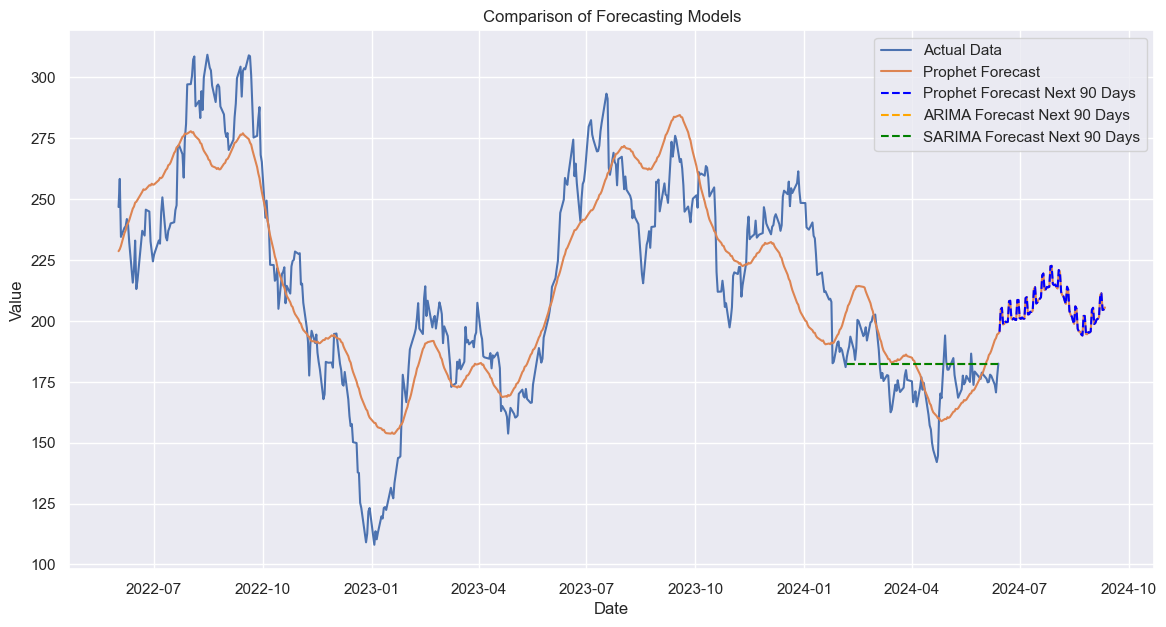

In [79]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use all data for training
train = df.copy()

# Define the last 90 days as the test period
test = df.iloc[-90:]

# Prophet model
prophet_model = Prophet()
prophet_model.fit(train)

# Forecast next 90 days with Prophet
future = prophet_model.make_future_dataframe(periods=90)
forecast_prophet = prophet_model.predict(future)
prophet_pred = forecast_prophet.iloc[-90:]['yhat'].values

# ARIMA model
arima_model = auto_arima(train['y'], seasonal=False, stepwise=True)
arima_forecast = arima_model.predict(n_periods=90)

# SARIMA model
sarima_model = auto_arima(train['y'], seasonal=True, m=7, stepwise=True)
sarima_forecast = sarima_model.predict(n_periods=90)

# Evaluation Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

def evaluate_model(true, pred, model_name):
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(true, pred)
    smape = symmetric_mean_absolute_percentage_error(true, pred)
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, sMAPE: {smape:.2f}%")

# Evaluate models on the last 90 days
print("Evaluation on last 90 days:")
evaluate_model(test['y'].values, prophet_pred, "Prophet")
evaluate_model(test['y'].values, arima_forecast, "ARIMA")
evaluate_model(test['y'].values, sarima_forecast, "SARIMA")

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['ds'], df['y'], label='Actual Data')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Forecast')
plt.plot(forecast_prophet['ds'][-90:], forecast_prophet['yhat'][-90:], linestyle='--', color='blue', label='Prophet Forecast Next 90 Days')
plt.plot(df['ds'][-90:], arima_forecast, linestyle='--', color='orange', label='ARIMA Forecast Next 90 Days')
plt.plot(df['ds'][-90:], sarima_forecast, linestyle='--', color='green', label='SARIMA Forecast Next 90 Days')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Forecasting Models')
plt.legend()
plt.show()

**Prophet** has best performance among all, as evident from graph, it has variation in data compared to ARIMA with straight line (mean prediction) even though the metrics says otherwise.

## Why I choose Prophet over ARIMA?

#### Advantages of Prophet

- **Scalability**: Suitable for large datasets with daily observations.
- **Flexibility**: Easily handles various types of seasonality and trend changes.
- **Intuitiveness**: Designed for both novice users and expert analysts.
- **Customization**: Allows incorporating domain knowledge through manual adjustments of parameters and inclusion of special events.

Prophet is particularly effective for business forecasting tasks such as capacity planning, goal setting, and anomaly detection. It provides a practical balance between model complexity and usability, making it a preferred choice for many organizations.

| Feature/Aspect         | Prophet                               | ARIMA                                 |
|------------------------|---------------------------------------|---------------------------------------|
| **Ease of Use**        | User-friendly, automated forecasting   | Requires manual parameter selection   |
| **Seasonality**        | Handles multiple seasonality patterns | Requires explicit handling (differencing) |
| **Holidays & Events**  | Built-in support                      | Manual incorporation                  |
| **Forecast Uncertainty**| Provides uncertainty intervals       | Requires additional steps             |
| **Robustness**         | Robust to missing data and outliers    | Sensitive to missing data and outliers |
| **Scalability**        | Efficient for large datasets          | Can become computationally intensive  |
| **Interpretability**   | Clear visualizations, easy to interpret | Requires deeper statistical knowledge |
| **Flexibility**        | Automated handling of data quirks     | Traditional statistical framework     |

---

### References
- Website: https://facebook.github.io/prophet/docs/quick_start.html#python-api
- Github Repo (Prophet): https://github.com/facebook/prophet
- Paper:PeerJ Preprints, "Forecasting at Scale", https://doi.org/10.7287/peerj.preprints.3190v2.